## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

### 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異

In [0]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[ 2, 16, 32, 128, 256 ]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in range(1):
    keras.backend.clear_session() # 把舊的 Graph 清掉, 非清不可
   
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM) #optimizer是變數
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer) #compile Model
    
    #train Model
    model.fit(x_train, y_train,   
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results; model.history收集
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-%s" % str(i) #定義Key名稱, 並將結果存至results{}; dic可以包小dic
    results[exp_name_tag] = {'train-loss': train_loss, 
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0719 02:08:56.301575 140103235389312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0719 02:08:56.302897 140103235389312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 02:08:56.351125 140103235389312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 02:08:56.352262 140103235389312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W071

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 2)                 6146      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 8         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 16)                48        
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
hidden_layer3 (Dense)        (None, 32)                544       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
__________

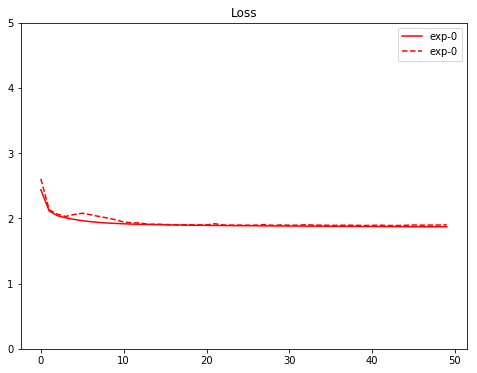

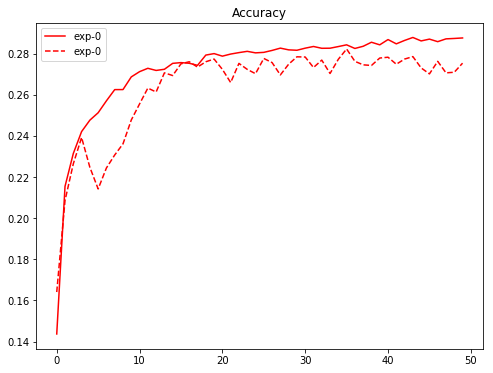

In [9]:

import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## hidden layer由小到大 比大到小還要差啊!! Why??

### 3. 請於 BN 放在 Input Layer 後，並比較結果

In [0]:
def build_mlp_b(input_shape, output_units=10, num_neurons=[ 2, 16, 32, 128, 256 ]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            #x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [27]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in range(1):
    keras.backend.clear_session() # 把舊的 Graph 清掉, 非清不可
   
    model = build_mlp_b(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM) #optimizer是變數
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer) #compile Model
    
    #train Model
    model.fit(x_train, y_train,   
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results; model.history收集
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-%s" % str(i) #定義Key名稱, 並將結果存至results{}; dic可以包小dic
    results[exp_name_tag] = {'train-loss': train_loss, 
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 2)                 6146      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 16)                48        
_________________________________________________________________
hidden_layer3 (Dense)        (None, 32)                544       
_________________________________________________________________
hidden_layer4 (Dense)        (None, 128)               4224      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 256)               33024     
__________

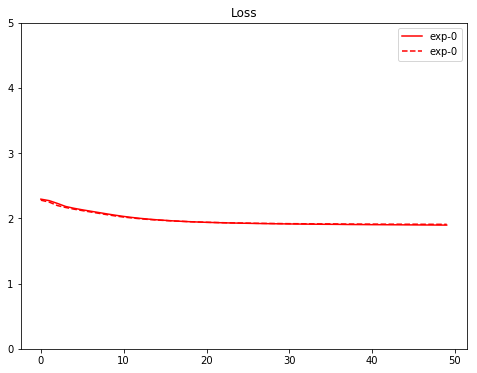

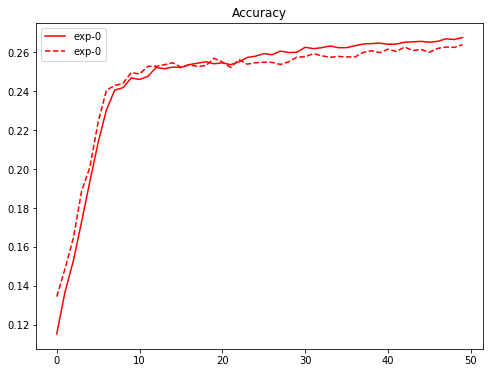

In [28]:

import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### 2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

test again, change another way

In [0]:
######???? 怎麼宣告BatchNormalization在中間啊??

'''
from keras.layers import BatchNormalization

def build_mlp_m(input_shape, output_units=10, num_neurons=[ 2, 16, 32, 128, 256 ]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,  
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            #x = keras.activations.relu(x) #怎麼宣告啊??
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation


In [0]:
#改成sequential吧

keras.backend.clear_session() # 把舊的 Graph 清掉, 非清不可 

model = Sequential()
model.add(Dense(2, input_dim=x_train.shape[1])) #input
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10))                      #output
model.add(BatchNormalization())
model.add(Activation('softmax'))

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6146      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 8         
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                48        
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
__________

In [55]:
x_train.shape[1]*2+2  #para

6146

In [59]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
    
exp_name_tag = "exp-%s" % str('middle') #定義Key名稱, 並將結果存至results{}; dic可以包小dic
results[exp_name_tag] = {'train-loss': train_loss, 
                         'valid-loss': valid_loss,
                          'train-acc': train_acc,
                          'valid-acc': valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 74us/step - loss: 2.3944 - acc: 0.1542 - val_loss: 2.4603 - val_acc: 0.1774
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.1609 - acc: 0.2098 - val_loss: 2.3898 - val_acc: 0.1497
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.0749 - acc: 0.2357 - val_loss: 2.2405 - val_acc: 0.1615
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.0313 - acc: 0.2457 - val_loss: 2.1346 - val_acc: 0.1949
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 2.0058 - acc: 0.2518 - val_loss: 2.0784 - val_acc: 0.2051
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.9848 - acc: 0.2614 - val_loss: 1.9999 - val_acc: 0.2480
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.9688 - acc: 0.2671 - val_loss: 1.9823 - val_acc

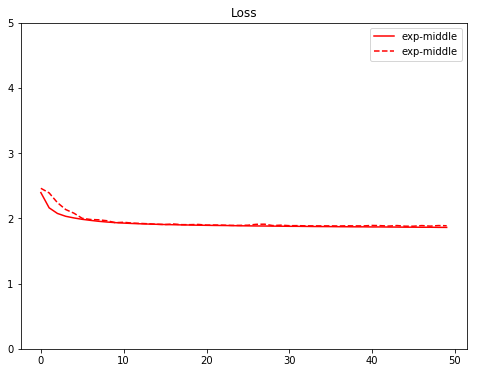

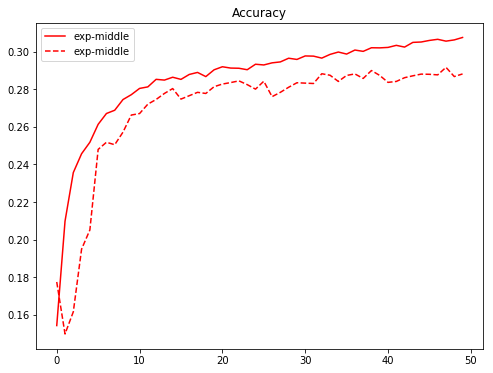

In [60]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## BN放在Dense及Activation中間效果, 比放Input後面還要好